In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# First step will be to import the feature data and the labels
data_filename = "data.csv"
data = pd.read_csv(data_filename)
data

,participant_id,trial_number,window_number,valence,arousal,dominance,liking,channel 1,channel 2,channel 3,...,channel 23,channel 24,channel 25,channel 26,channel 27,channel 28,channel 29,channel 30,channel 31,channel 32
0,1,1,1,7.71,7.60,6.90,7.83,0.020185,0.023363,0.018405,...,0.013804,0.003827,0.011471,0.008052,0.034050,0.014819,0.025781,0.046516,0.041236,0.030406
1,1,1,2,7.71,7.60,6.90,7.83,0.018202,0.022950,0.033891,...,0.002769,0.000000,0.065416,0.008608,0.034954,0.004006,0.033779,0.022557,0.048491,0.034563
2,1,1,3,7.71,7.60,6.90,7.83,0.133390,0.169650,0.193530,...,0.107730,0.115290,0.016749,0.191440,0.166740,0.095686,0.177980,0.247960,0.191230,0.182040
3,1,1,4,7.71,7.60,6.90,7.83,0.012445,0.006768,0.000000,...,0.011967,0.010997,0.001332,0.000000,0.028595,0.062554,0.012688,0.065016,0.017439,0.015032
4,1,1,5,7.71,7.60,6.90,7.83,0.022346,0.001802,0.012496,...,0.031683,0.025986,0.006566,0.040331,0.009964,0.021910,0.029073,0.024466,0.036120,0.045797
5,1,2,1,8.10,7.31,7.28,8.47,0.113840,0.082707,0.065647,...,0.064674,0.019731,0.063272,0.009438,0.024409,0.013781,0.063709,0.044422,0.066293,0.079455
6,1,2,2,8.10,7.31,7.28,8.47,0.000000,0.000000,0.002725,...,0.011603,0.009414,0.012390,0.012992,0.016413,0.044989,0.000000,0.018630,0.006297,0.013527
7,1,2,3,8.10,7.31,7.28,8.47,0.017704,0.038337,0.027485,...,0.008545,0.008569,0.015771,0.011793,0.008005,0.001467,0.000000,0.019411,0.022187,0.041255
8,1,2,4,8.10,7.31,7.28,8.47,0.001534,0.010361,0.002094,...,0.033378,0.047389,0.007728,0.025984,0.036796,0.007562,0.011822,0.028745,0.021169,0.011014
9,1,2,5,8.10,7.31,7.28,8.47,0.080747,0.065554,0.049336,...,0.121130,0.146740,0.060103,0.010205,0.044471,0.186840,0.047762,0.005171,0.072261,0.105110


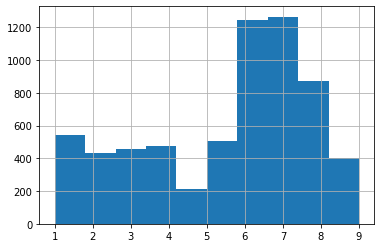

In [5]:
data['arousal'].hist()
plt.show()

In [6]:
# We will be trying to classify based on arousal for this experiment
y = data[['participant_id','trial_number','window_number','arousal']];
number_connections = 496
channel_names = [ "connection " + str(i) for i in range(1,number_connections+1)]
X = data[['participant_id', 'trial_number','window_number'] + channel_names]

In [7]:
# Should leave one of the subject out of the classification and use the rest for training a basic
# Need to look at ai.py in the Scritps/AEC vs wPLI Comparison project
# Machine Learning 

# Will do minmax normalization on the features
from sklearn import preprocessing

# This is how we would normalize the data
# However we need to normalize each time in the training set and the test set independently (can't do it on the whole set)
example_min_max_scaler = preprocessing.MinMaxScaler()
example_data = example_min_max_scaler.fit_transform(data[channel_names].values)

In [ ]:
# Let's look at the class imbalance first
arousal_label_count = data['arousal'].value_counts()
print('Class 0:', arousal_label_count[0])
print('Class 1:', arousal_label_count[1])
print('Proportion:', round(arousal_label_count[0] / arousal_label_count[1], 2), ': 1')

arousal_label_count.plot(kind='bar', title='Count (target)');

# TODO: At this point we need to check if we want to let it run without resampling or with resampling
# from what I saw with the histogram above it's skew toward high arousal and high valence so we will to resample

# Divide by class of low and high arousal
data_arousal_0 = data[data['arousal'] == 0]
data_arousal_1 = data[data['arousal'] == 1]

# Undersampling the arousal high class (data_arousal_1)
data_arousal_1_under = data_arousal_1.sample(arousal_label_count[0])
data_test_under = pd.concat([data_arousal_0, data_arousal_1_under], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');


In [10]:
# Classification 
# we want to do a first run where we check which classifiers from a list is better for this task (will go with svm only)
# TODO: use a pipeline over here that will help a lot with the scaling and then the classification
# Machine Learning 
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import clone
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

number_participants = np.max(data['participant_id'].values)
clf_label = 'arousal'
clfs = [LinearDiscriminantAnalysis(solver='svd'), SVC(kernel='linear', C=0.1),SVC(kernel='linear', C=0.5), SVC(kernel='linear', C=1.0), SVC(kernel='rbf', C=0.1), SVC(kernel='rbf',C=1.0)]

# Classification function with LOSO cross validation
def classify(dataframe, template_clf, number_participants, channel_names, clf_label):
    clf = clone(template_clf)
    
    scores = []
    # Need to do +1 to have the last id
    for test_participant_id in range(1,number_participants+1):
        print("Participant: " + str(test_participant_id) + " in hold-out set:")
        
        # Getting the training and test dataframe
        test_dataframe = dataframe.loc[dataframe['participant_id'] == test_participant_id].copy(deep=True)
        train_dataframe = dataframe.loc[dataframe['participant_id'] != test_participant_id].copy(deep=True)
        
        # Preprocessing the train and test data
        train_min_max_scaler = preprocessing.MinMaxScaler()
        train_dataframe[channel_names] = train_min_max_scaler.fit_transform(train_dataframe[channel_names].values)
        
        test_min_max_scaler = preprocessing.MinMaxScaler()
        test_dataframe[channel_names] = test_min_max_scaler.fit_transform(test_dataframe[channel_names].values)
        
        # training the regressor on the training data (using arousal here)
        X_train = train_dataframe[channel_names];
        y_train = train_dataframe[reg_label]
        clf.fit(X_train, y_train)
        
        # testing the regressor on the holdout participant data
        X_test = test_dataframe[channel_names]
        y_true = test_dataframe[reg_label]
        y_pred = clf.predict(X_test)
        
        # Log the result information to the screen
        conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
        print('Confusion matrix:\n', conf_mat)
        accuracy = accuracy_score(y_true, y_pred)
        print("Generalization accuracy: " + str(accuracy))
        
        scores.append(accuracy)  
    return scores
        
classify(data,clfs[4],number_participants, channel_names,clf_label)

Participant: 1 in hold-out set:
R2 score = -0.09854474404586955
Participant: 2 in hold-out set:
R2 score = -0.013456047486896106
Participant: 3 in hold-out set:
R2 score = -1.0400200059109808
Participant: 4 in hold-out set:
R2 score = -0.4956504740625751
Participant: 5 in hold-out set:
R2 score = -0.05774806928550591
Participant: 6 in hold-out set:
R2 score = -0.0649668445452658
Participant: 7 in hold-out set:
R2 score = -0.1287036153423764
Participant: 8 in hold-out set:
R2 score = -0.19555206740797826
Participant: 9 in hold-out set:
R2 score = -0.1402917596301756
Participant: 10 in hold-out set:
R2 score = -0.12494406121349888
Participant: 11 in hold-out set:
R2 score = -0.3821122835762676
Participant: 12 in hold-out set:
R2 score = -0.6909220632796613
Participant: 13 in hold-out set:
R2 score = -0.6371652793850398
Participant: 14 in hold-out set:
R2 score = -0.18012195685119758
Participant: 15 in hold-out set:
R2 score = -0.24360349583897767
Participant: 16 in hold-out set:
R2 score

[-0.09854474404586955,
 -0.013456047486896106,
 -1.0400200059109808,
 -0.4956504740625751,
 -0.05774806928550591,
 -0.0649668445452658,
 -0.1287036153423764,
 -0.19555206740797826,
 -0.1402917596301756,
 -0.12494406121349888,
 -0.3821122835762676,
 -0.6909220632796613,
 -0.6371652793850398,
 -0.18012195685119758,
 -0.24360349583897767,
 -0.1208326857348132,
 -0.0867328659543769,
 -0.2076173156220691,
 -0.055303649823275514,
 -0.14198686771423197,
 -0.5910930989568728,
 0.020242715479214968,
 -0.58274369273895,
 -0.3345429795031851,
 -0.09118425700631438,
 -0.12110921661669627,
 -0.027970220893452913,
 -0.056961863703298254,
 -0.00462441268068714,
 -0.10694622345337113,
 -0.04517413872411513,
 -0.08790911059269924]

In [14]:
# The regressor is not great, maybe its due by the features not being useful, let's look at the correlation
data[['arousal'] + channel_names].corr()['arousal'][:]

arousal       1.000000
channel 1     0.022173
channel 2     0.010103
channel 3     0.019768
channel 4    -0.016271
channel 5    -0.002032
channel 6     0.015941
channel 7     0.003083
channel 8    -0.004409
channel 9     0.006122
channel 10    0.001835
channel 11    0.015637
channel 12    0.003842
channel 13    0.027064
channel 14   -0.000724
channel 15    0.002748
channel 16    0.013164
channel 17   -0.000735
channel 18    0.021915
channel 19    0.002464
channel 20    0.028937
channel 21    0.014862
channel 22   -0.006727
channel 23    0.004954
channel 24    0.004736
channel 25    0.009416
channel 26    0.014083
channel 27    0.014867
channel 28    0.007758
channel 29    0.028069
channel 30    0.007169
channel 31    0.018539
channel 32   -0.009576
Name: arousal, dtype: float64